In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, mean_squared_error, classification_report, confusion_matrix
from xgboost import XGBRegressor
import joblib

In [23]:
file_path = 'dataset_cleaned (1).csv' 
df = pd.read_csv(file_path)

In [24]:
df['playlist_genre'].value_counts()  


playlist_genre
rap      5179
pop      4978
edm      4837
r&b      4259
rock     4079
latin    4017
Name: count, dtype: int64

Selected features:
['loudness' 'acousticness' 'danceability' 'tempo' 'energy' 'speechiness'
 'liveness' 'valence']
Popularity MSE: 0.05402686143366499
Popularity R2: 0.057570966767662046


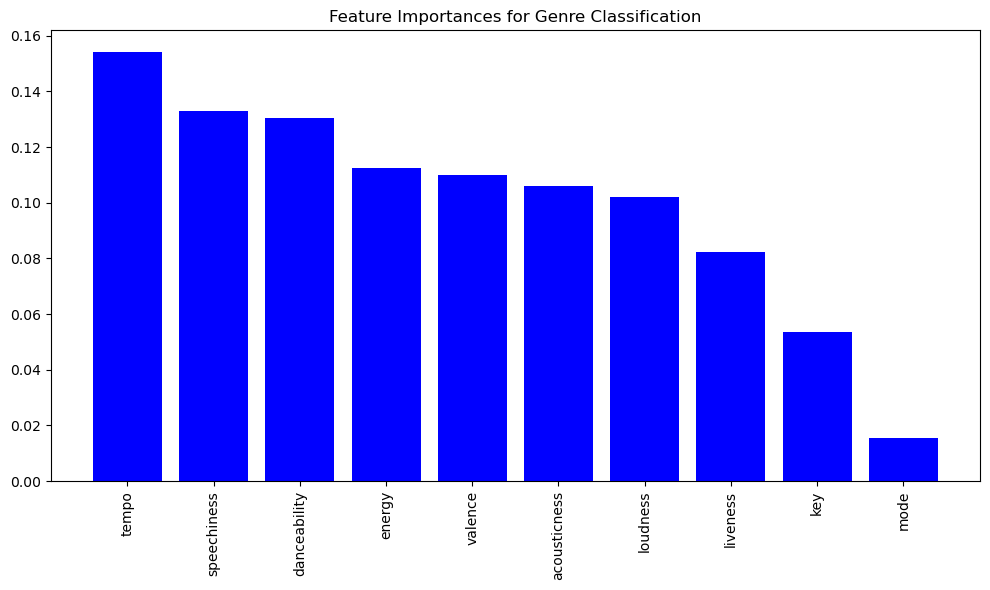

Selected features:
['loudness' 'acousticness' 'danceability' 'tempo' 'energy' 'speechiness'
 'valence']
[-0.27568512  1.55120216 -0.83768838 -0.42071192 -0.3512138  -0.81217536
 -0.66683019]
RandomForest Genre Accuracy (after tuning): 0.5317025440313111
Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.68      0.66       912
           1       0.46      0.37      0.41       720
           2       0.41      0.39      0.40       969
           3       0.45      0.44      0.44       785
           4       0.57      0.62      0.59       957
           5       0.63      0.67      0.65       767

    accuracy                           0.53      5110
   macro avg       0.53      0.53      0.53      5110
weighted avg       0.53      0.53      0.53      5110

Confusion Matrix:
 [[618  43 137  28  52  34]
 [ 73 269 123  94 130  31]
 [157  92 376 117  97 130]
 [ 26  76  97 342 169  75]
 [ 52  73  78 124 595  35]
 [ 39  33 114  54  10 517

In [25]:



file_path = 'dataset_cleaned (1).csv'  
df = pd.read_csv(file_path)


X = df[['loudness', 'acousticness', 'danceability', 'tempo', 'energy', 'key', 'speechiness', 'liveness', 'valence', 'mode']]
y_popularity = df['track_popularity']  # Numerical target
y_genre = df['playlist_genre']  # Categorical target

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

encoder = LabelEncoder()
y_genre_encoded = encoder.fit_transform(y_genre)

joblib.dump(encoder, 'label_encoder.pkl')


z_scores_scaled = np.abs(stats.zscore(X_scaled))

# Create a mask to remove rows with Z-scores > 3
mask_no_outliers_zscore = (z_scores_scaled < 3).all(axis=1)
X_scaled_no_outliers_zscore = X_scaled[mask_no_outliers_zscore]  
y_popularity_no_outliers_zscore = y_popularity[mask_no_outliers_zscore]
y_genre_no_outliers_zscore = y_genre[mask_no_outliers_zscore]

pop_scaler = MinMaxScaler(feature_range=(0, 1))
y_popularity_scaled_final = pop_scaler.fit_transform(y_popularity_no_outliers_zscore.values.reshape(-1, 1))

encoder = LabelEncoder()
y_genre_encoded_final = encoder.fit_transform(y_genre_no_outliers_zscore)

X_train, X_test, y_pop_train, y_pop_test, y_gen_train, y_gen_test = train_test_split(
    X_scaled_no_outliers_zscore, y_popularity_scaled_final, y_genre_encoded_final, test_size=0.2, random_state=42
)

rf_regressor = RandomForestRegressor()
rf_regressor.fit(X_train, y_pop_train.ravel())

selector = SelectFromModel(rf_regressor, threshold="mean", prefit=True)
X_train_selected = selector.transform(X_train)  
X_test_selected = selector.transform(X_test)
feature_names = ['loudness', 'acousticness', 'danceability', 'tempo', 'energy', 'key', 'speechiness', 'liveness', 'valence', 'mode']
selected_features = np.array(feature_names)[selector.get_support()]
print("Selected features:")
print(selected_features)

scaler = StandardScaler()
X_trained_selected_scaled = scaler.fit_transform(X_train_selected)
X_test_selected_scaled = scaler.fit_transform(X_test_selected)

joblib.dump(scaler, 'scaler_regeressor.pkl')

best_xgb_regressor = XGBRegressor(colsample_bytree=1, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=0.8)
best_xgb_regressor.fit(X_trained_selected_scaled, y_pop_train.ravel())

y_pop_pred = best_xgb_regressor.predict(X_test_selected)

y_pop_pred_rescaled = pop_scaler.inverse_transform(y_pop_pred.reshape(-1, 1))

print('Popularity MSE:', mean_squared_error(y_pop_test, y_pop_pred))
print('Popularity R2:', best_xgb_regressor.score(X_test_selected_scaled, y_pop_test))

joblib.dump(best_xgb_regressor, 'best_xgb_regressor.pkl')


rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train, y_gen_train)

importances_genre = rf_classifier.feature_importances_
indices_genre = np.argsort(importances_genre)[::-1]


plt.figure(figsize=(10,6))
plt.title("Feature Importances for Genre Classification")
plt.bar(range(X_train.shape[1]), importances_genre[indices_genre], color="b", align="center")
plt.xticks(range(X_train.shape[1]), np.array(X.columns)[indices_genre], rotation=90)
plt.tight_layout()
plt.show()

selector_genre = SelectFromModel(rf_classifier, threshold="mean", prefit=True)
X_train_selected_genre = selector_genre.transform(X_train)  # Ensure NumPy array
X_test_selected_genre = selector_genre.transform(X_test)
selected_features = np.array(feature_names)[selector_genre.get_support()]
print("Selected features:")
print(selected_features)

scaler_g = StandardScaler()
X_trained_selected_genre_scaled = scaler_g.fit_transform(X_train_selected_genre)
print(X_trained_selected_genre_scaled[0])
X_test_selected_genre_scaled = scaler_g.fit_transform(X_test_selected_genre)

joblib.dump(scaler_g, 'scaler_classifier.pkl')

genre_model = RandomForestClassifier()
genre_model.fit(X_trained_selected_genre_scaled, y_gen_train)
y_gen_pred = genre_model.predict(X_test_selected_genre_scaled)


joblib.dump(genre_model, 'rf_classifier_model.pkl')

genre_accuracy = accuracy_score(y_gen_test, y_gen_pred)
print('RandomForest Genre Accuracy (after tuning):', genre_accuracy)
print("Classification Report:\n", classification_report(y_gen_test, y_gen_pred))
print("Confusion Matrix:\n", confusion_matrix(y_gen_test, y_gen_pred))


